In [1]:
import numpy as np # linear algebra
import tensorflow as tf # for tensorflow based registration
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage
import os
from cv2 import imread, createCLAHE # read and equalize images
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import pathlib
import time
import datetime

from IPython import display
from skimage.util import montage as montage2d

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Step 1: Data Loading and Preprocessing

In [2]:
cxr_paths = glob(os.path.join('..', 'input', 'pulmonary-chest-xray-abnormalities',
                              'Montgomery', 'MontgomerySet','*','*.png'))


In [3]:
cxr_images = [(c_path, 
               [os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','leftMask', os.path.basename(c_path)),
               os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','rightMask', os.path.basename(c_path))]
              ) for c_path in cxr_paths]


In [4]:
print('CXR Images', len(cxr_paths), cxr_paths[0])
print(cxr_images[0])

CXR Images 138 ../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0017_0.png
('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0017_0.png', ['../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/MCUCXR_0017_0.png', '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/MCUCXR_0017_0.png'])


In [5]:
# Loading the images and resizing them all, if wanted, apply CLAHE
from skimage.io import imread as imread_raw
from skimage.transform import resize
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore', category=UserWarning, module='skimage') # skimage is really annoying
OUT_DIM = (256, 256)
def imread(in_path, apply_clahe = False):
    img_data = imread_raw(in_path)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.float64)
    if apply_clahe:
        clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
        n_img = clahe_tool.apply(n_img)
    return np.expand_dims(n_img, -1)

In [6]:
img_vol, seg_vol = [], []
for img_path, s_paths in tqdm(cxr_images):
    img_vol += [imread(img_path)]    
    seg_vol += [np.max(np.stack([imread(s_path, apply_clahe = False) for s_path in s_paths],0),0)]
img_vol = np.stack(img_vol,0)
seg_vol = np.stack(seg_vol,0)
print('Images', img_vol.shape, 'Segmentations', seg_vol.shape)

100%|██████████| 138/138 [04:45<00:00,  2.07s/it]

Images (138, 256, 256, 1) Segmentations (138, 256, 256, 1)


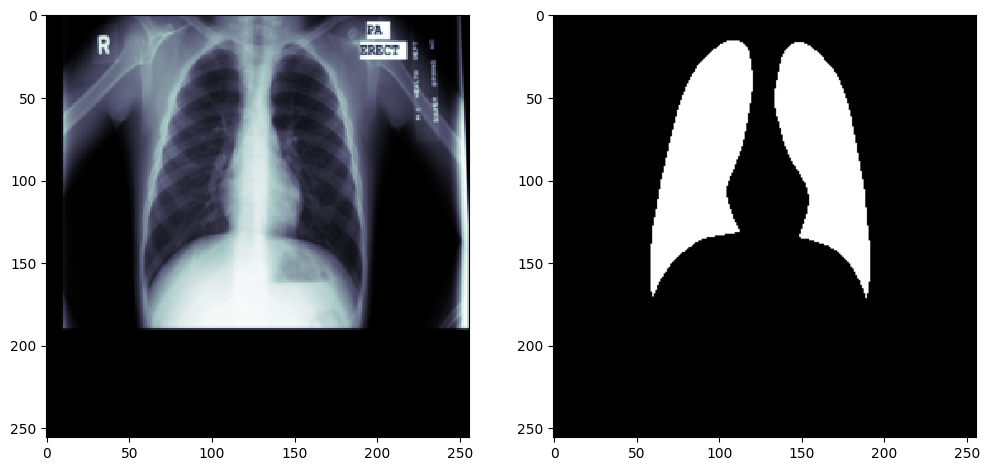

In [7]:
# Showing one random image together with its mask
np.random.seed(2018)
t_img, m_img = img_vol[0], seg_vol[0]

fig, (ax_img, ax_mask) = plt.subplots(1,2, figsize = (12, 6))
ax_img.imshow(np.clip(255*t_img, 0, 255).astype(np.float) if t_img.shape[2]==3 else t_img[:,:,0],
              interpolation = 'none', cmap = 'bone')
ax_mask.imshow(m_img[:,:,0], cmap = 'bone')

Train (110, 256, 256, 1) Test (28, 256, 256, 1) -0.14468614289825316 1.0078740157480315
Seg (110, 256, 256, 1) 1.0 [0. 1.]


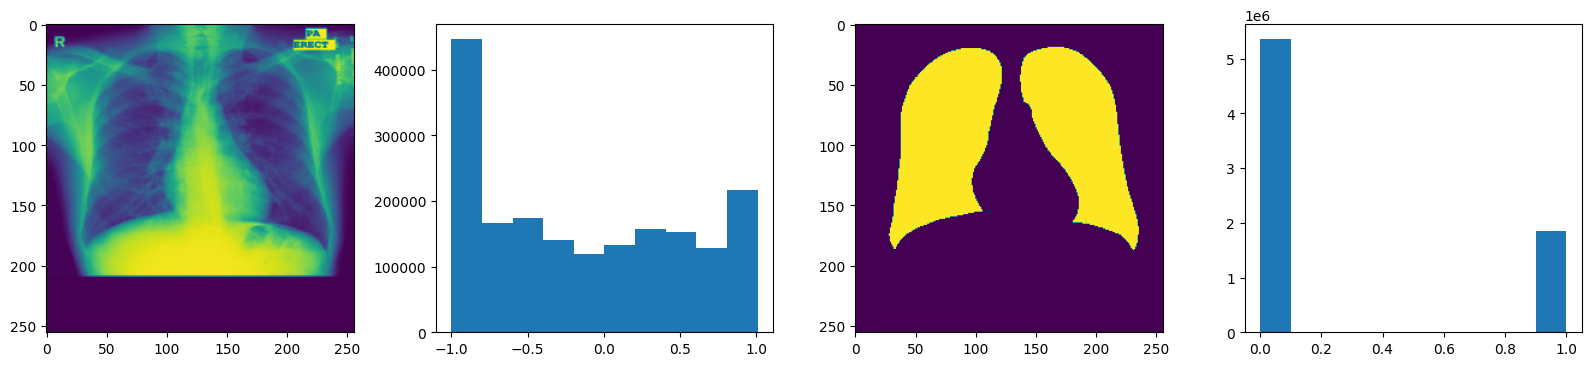

In [8]:
from sklearn.model_selection import train_test_split
train_vol, test_vol, train_seg, test_seg = train_test_split((img_vol-127.0)/127.0, 
                                                            (seg_vol>127).astype(np.float32), 
                                                            test_size = 0.2, 
                                                            random_state = 2018)
print('Train', train_vol.shape, 'Test', test_vol.shape, test_vol.mean(), test_vol.max())
print('Seg', train_seg.shape, train_seg.max(), np.unique(train_seg.ravel()))
fig, (ax1, ax1hist, ax2, ax2hist) = plt.subplots(1, 4, figsize = (20, 4))
ax1.imshow(test_vol[0, :, :, 0])
ax1hist.hist(test_vol.ravel())
ax2.imshow(test_seg[0, :, :, 0]>0.5)
ax2hist.hist(train_seg.ravel());

Step 2: Data Augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5, 
                  width_shift_range = 0.05, 
                  height_shift_range = 0.05, 
                  shear_range = 0.01,
                  zoom_range = [0.8, 1.2],  
               # anatomically it doesnt make sense, but many images are flipped
                  horizontal_flip = True,  
                  vertical_flip = False,
                  fill_mode = 'nearest',
               data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)
test_img_gen = ImageDataGenerator()

def gen_augmented_pairs(in_vol, in_seg, batch_size = 1, train = True):
    while True:
        if train == True:
            seed = np.random.choice(range(9999))
            # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
            g_vol = image_gen.flow(in_vol, batch_size = batch_size, seed = seed)
            g_seg = image_gen.flow(in_seg, batch_size = batch_size, seed = seed)
            for i_vol, i_seg in zip(g_vol, g_seg):
                yield i_vol, i_seg
        else:
            seed = 0
            g_vol = test_img_gen.flow(in_vol, batch_size = batch_size, seed = seed)
            g_seg = test_img_gen.flow(in_seg, batch_size = batch_size, seed = seed)
            for i_vol, i_seg in zip(g_vol, g_seg):
                yield i_vol, i_seg

In [10]:
# We use a batch size of only 1 for our GAN, however, for the montage at the end a 16 batchsize is needed
train_gen = gen_augmented_pairs(train_vol, train_seg, batch_size = 1)
test_gen = gen_augmented_pairs(test_vol, test_seg, batch_size = 1, train = False)
test_gen_16 = gen_augmented_pairs(test_vol, test_seg, batch_size = 16, train = False)
train_X, train_Y = next(train_gen)
test_X, test_Y = next(test_gen)
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(1, 256, 256, 1) (1, 256, 256, 1)
(1, 256, 256, 1) (1, 256, 256, 1)


Text(0.5, 1.0, 'Seg Image')

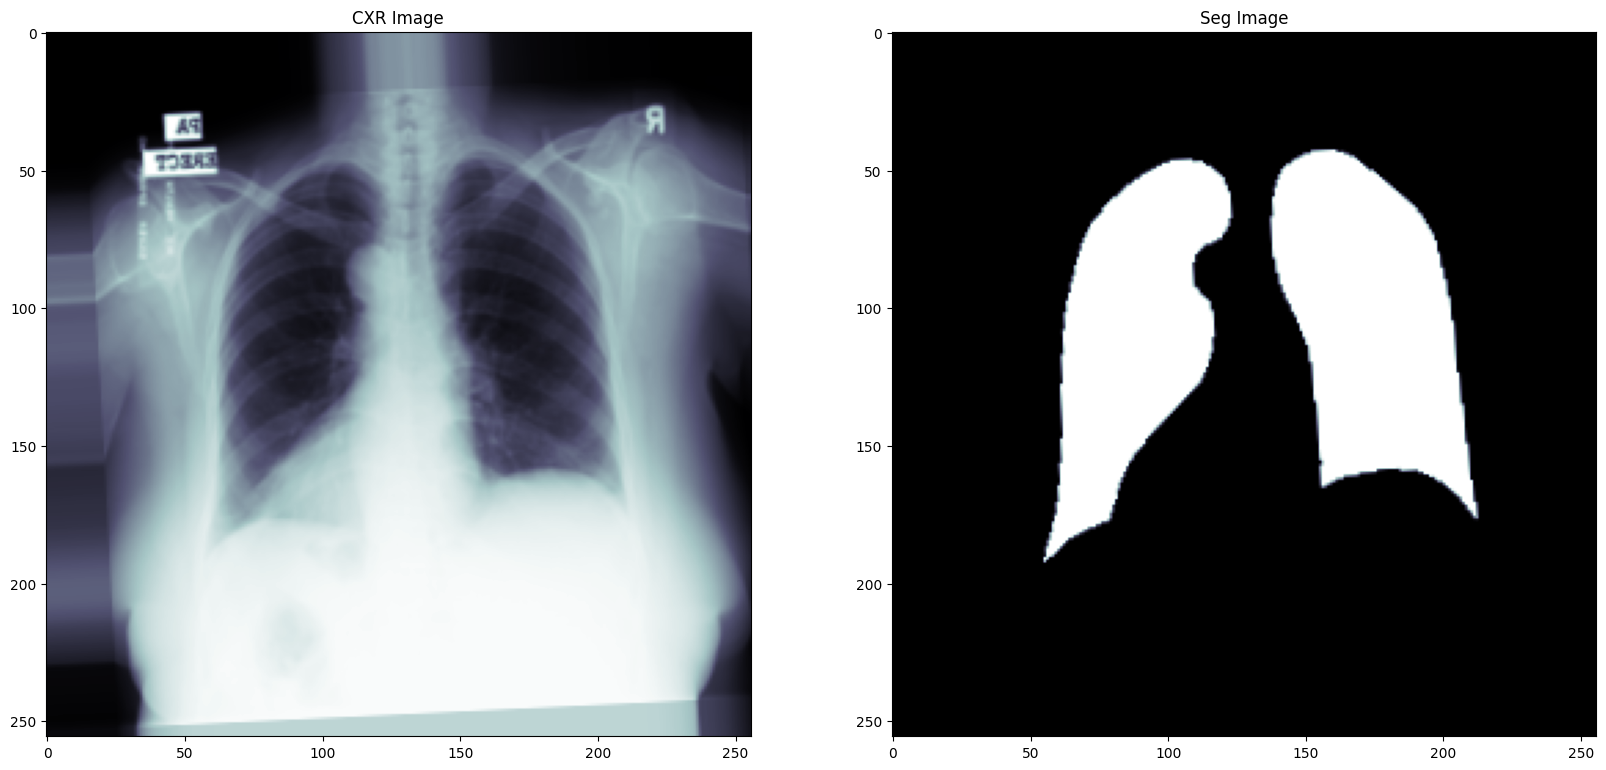

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage2d(train_X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('CXR Image')
ax2.imshow(montage2d(train_Y[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Seg Image')

Model definition

Step 3: U-Net Model Definition

In [12]:
# The x ray training set consist of 400 images
BUFFER_SIZE = 133
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

OUTPUT_CHANNELS = 1

In [13]:
# Helping function for the encoding part

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())

    return result

In [14]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(t_img, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [15]:
# Helping function for the decoding part

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())

    return result

In [16]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [17]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') 
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

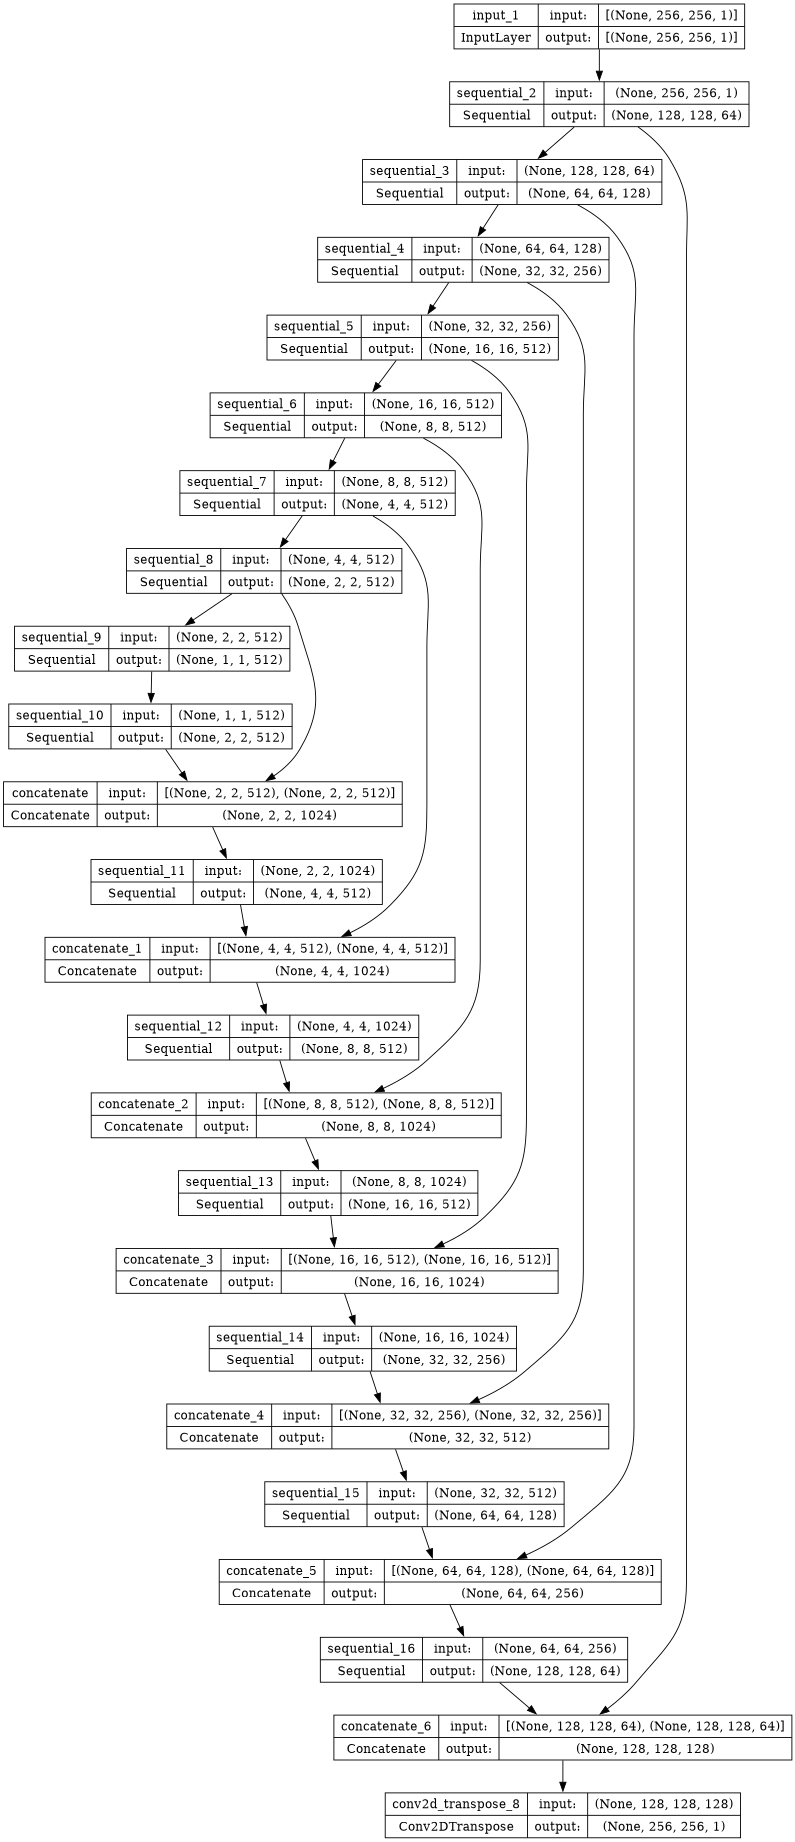

In [18]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [19]:
LAMBDA = 100

In [20]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Step 4: Loss Functions

In [21]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [22]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                    kernel_initializer=initializer,
                                    use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                    kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)


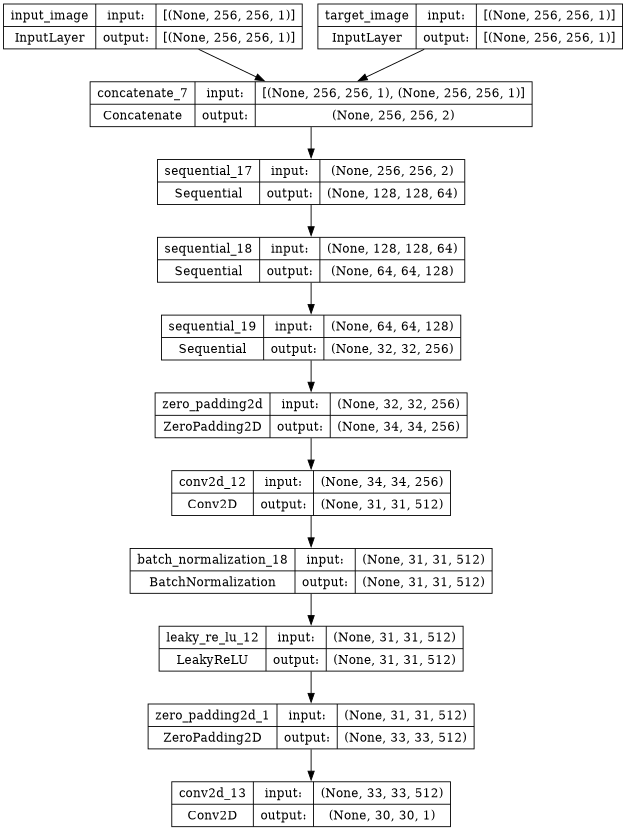

In [23]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

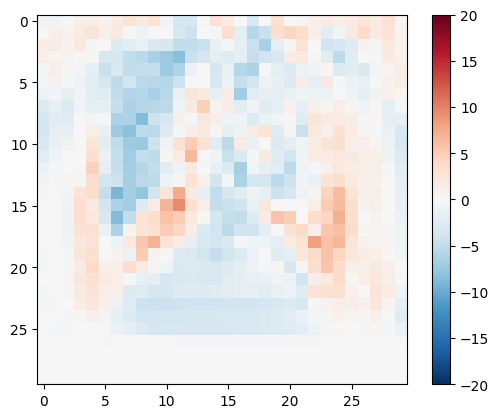

In [24]:
disc_out = discriminator([t_img[tf.newaxis, ...], m_img[tf.newaxis, ...]], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [25]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Step 5: Optimization and Checkpoint Setup

In [26]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
def generate_images(model, test_input, tar, metric = None, show = False, return_prediction = False):
    prediction = model(test_input, training=True)
    
    
    if show == True:
        plt.figure(figsize=(15, 15))
        display_list = [test_input[0], tar[0], prediction[0]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # Getting the pixel values in the [0, 1] range to plot.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()
    if metric != None:
        metric.update_state(tar, prediction)
    if return_prediction == True:
        return prediction 

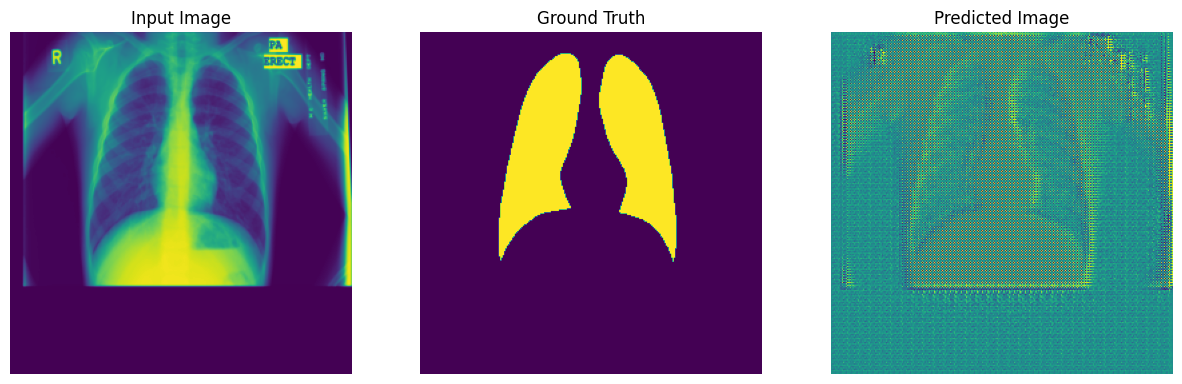

In [28]:
generate_images(generator, t_img[tf.newaxis, ...], m_img[tf.newaxis, ...], show = True)

Step 6: Training

In [29]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [30]:
@tf.function
def train_step(input_image, target, step, metric):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
    metric.update_state(target, gen_output)

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//10)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//10)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//10)
        tf.summary.scalar('disc_loss', disc_loss, step=step//10)
train_accuracies = []
test_accuracies = []

In [31]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(test_ds)    
    train_metric = tf.keras.metrics.BinaryAccuracy()
    test_metric = tf.keras.metrics.BinaryAccuracy()
    start = time.time()
    step = 0
    for input_image, target in train_ds:
        if (step) % 10 == 0:
            display.clear_output(wait=True)
            train_accuracies.append(train_metric.result().numpy())
            if step != 0:
                print(f'Time taken for {steps} steps: {time.time()-start:.2f} sec\n')

            start = time.time()

      ## Validation step
     
            generate_images(generator, example_input, example_target, metric = None, show = True)
            val_count = 0
            for test_img, test_target in test_ds:
                generate_images(generator, example_input, example_target, test_metric)
                val_count += 1
                if val_count >= 28:
                    break
            test_accuracies.append(test_metric.result().numpy())         
            print(f"Step: {step}")
            print(f"Training Accuracy: {train_metric.result().numpy()}")
            print(f"Validation Accuracy: {test_metric.result().numpy()}")
            train_metric.reset_states()
            test_metric.reset_states()
            if test_accuracies[-1] == max(test_accuracies):
                checkpoint.save(file_prefix=checkpoint_prefix)

        train_step(input_image, target, step, train_metric)

            # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)
                
        step += 1
        if step == steps:
            break

Time taken for 200 steps: 22.16 sec



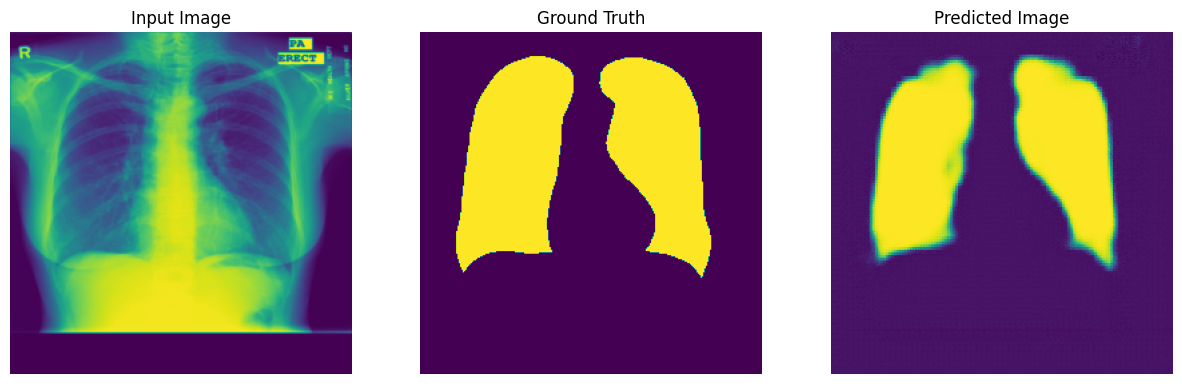

Step: 190
Training Accuracy: 0.9544662237167358
Validation Accuracy: 0.9619336724281311


2023-12-29 15:14:07.894500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-29 15:14:09.943970: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-29 15:14:11.964152: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-29 15:14:14.114377: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4

.

In [32]:
fit(train_gen, test_gen, steps=200)

In [33]:
# After running the training loop, you can print the lists
print("Training Accuracies:", train_accuracies)
print("Test Accuracies:", test_accuracies)

Training Accuracies: [0.0, 0.7103821, 0.8213501, 0.8799103, 0.89015657, 0.90254974, 0.9166458, 0.9387528, 0.92750853, 0.90700686, 0.928154, 0.93390197, 0.9310562, 0.9330475, 0.95003355, 0.9254654, 0.93132627, 0.94604796, 0.9570221, 0.9544662]
Test Accuracies: [0.71827424, 0.7629384, 0.89030296, 0.903377, 0.92169625, 0.91293335, 0.9514182, 0.9462046, 0.9636296, 0.9445381, 0.9561566, 0.9631108, 0.9600596, 0.9669576, 0.9586465, 0.95803994, 0.9738726, 0.9663658, 0.96229225, 0.9619337]


In [34]:
print('average training accuracy : ', np.mean(np.array(train_accuracies)))
print('average testing accuracy : ', np.mean(np.array(test_accuracies)))

average training accuracy :  0.8642392
average testing accuracy :  0.9271374


Testing an Image

In [35]:
test_vol = np.array(test_vol)
test_seg = np.array(test_seg)
test_img_vol_conv = (test_vol - 127.0) / 127.0 
test_seg_vol_conv = (test_seg > 127).astype(np.float32)

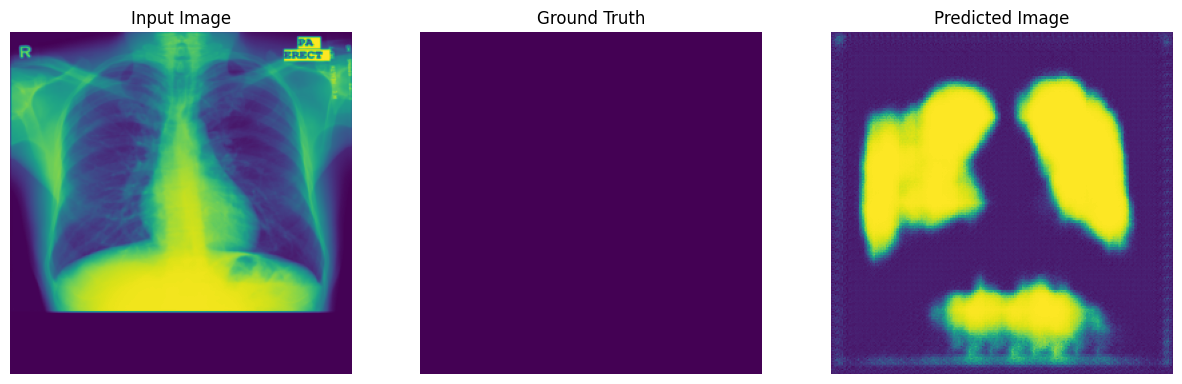

Test Accuracy: 0.84747314453125, Predicted Accuracy: 0.84747314453125
Final Test Accuracy: 0.7134909629821777


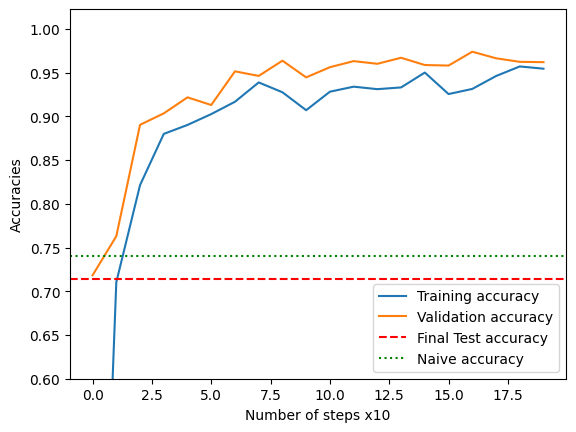

In [36]:
# Testing the Model
test_metric = tf.keras.metrics.BinaryAccuracy()

for i, (image, mask) in enumerate(zip(test_img_vol_conv, test_seg_vol_conv)):
    if i % 30 == 0:
        generate_images(generator, image[tf.newaxis, ...], mask[tf.newaxis, ...], test_metric, show=True)
        predicted_mask = generator(image[tf.newaxis, ...], training=False)
        accuracy = test_metric(mask[tf.newaxis, ...], predicted_mask)
        print(f"Test Accuracy: {test_metric.result().numpy()}, Predicted Accuracy: {accuracy.numpy()}")
    else:
        generate_images(generator, image[tf.newaxis, ...], mask[tf.newaxis, ...], test_metric, show=False)

final_test_accuracy = test_metric.result().numpy()
print(f"Final Test Accuracy: {final_test_accuracy}")

# Evaluation
plt.plot(train_accuracies, ls="-", label="Training accuracy")
plt.plot(test_accuracies, ls="-", label="Validation accuracy")
plt.axhline(final_test_accuracy, ls="--", label="Final Test accuracy", color="red")
plt.axhline(0.74, ls=":", label="Naive accuracy", color="green")
plt.ylabel('Accuracies')
plt.xlabel('Number of steps x10')
plt.legend(loc='lower right')
plt.ylim(0.6)
plt.show()
